# Self-Driving Car Engineer Nanodegree


## Project 2: **Advanced Lane Lines** 
***
The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---

## Import Packages

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import pickle

'output_images' folder contains undistorted test images created by camera_calibration.py

In [2]:
# using undistorted images created in camera_calibration.py that was writtent to output_images
images = glob.glob('./output_images/undistorted_test*.jpg')
num_images = len(images)

## Color Threshold
---
Compare the image's color channels to focus on the specific channels that do a better job of causing lane lines to stand-out.

channel test images


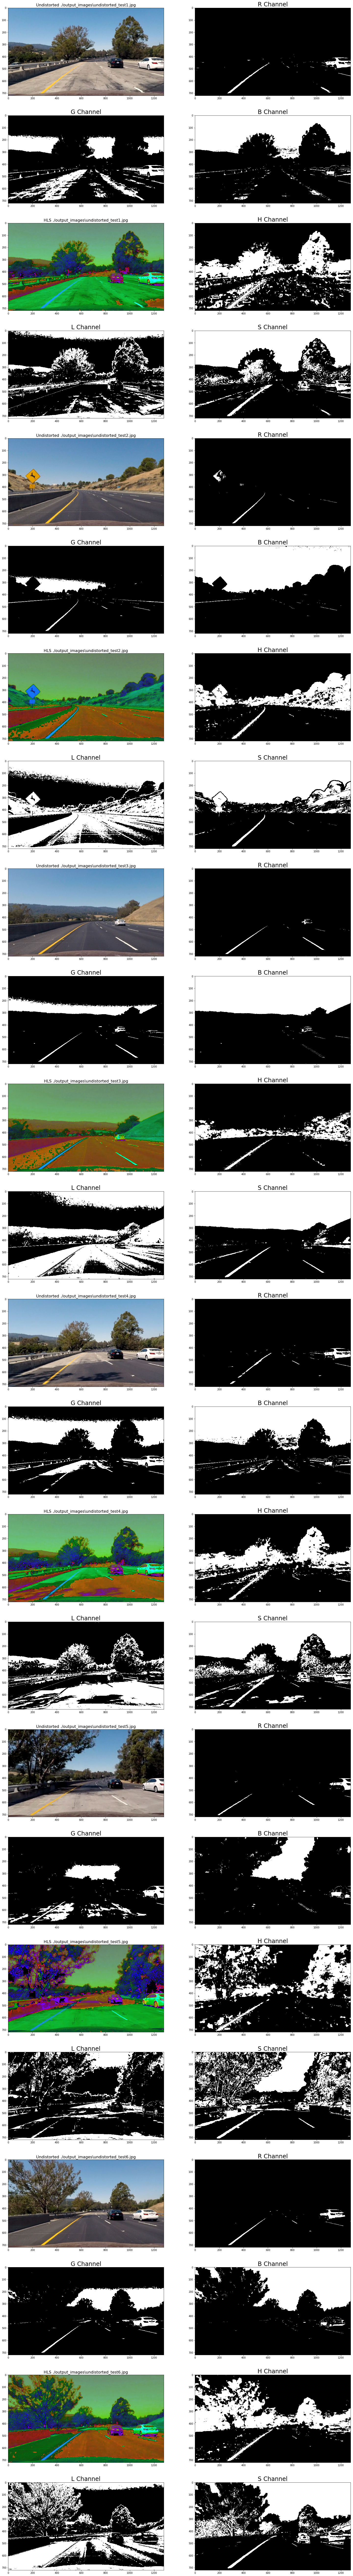

In [3]:
# applies a binary mask to help point-out which channel emphasizes the lane lines
def binaryMask(img, thresh):
    binary = np.zeros_like(img)
    binary[(img > thresh[0]) & (img <= thresh[1])] = 1
    return binary

fig, axes = plt.subplots(4*num_images, 2, figsize=(25,8 * 4*num_images)) # each image w/ 2 rows for rgb & 2 rows for hls

for i, fname in enumerate(images):
    image = mpimg.imread(fname) # rgb image
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS) # hls image
    
    # separating rgb channels
    R = image[:,:,0]
    G = image[:,:,1]
    B = image[:,:,2]
    # separating hls channels
    H = hls[:,:,0]
    L = hls[:,:,1]
    S = hls[:,:,2]

    # apply binary masks to each channel (thresholds tested to fit each channel)
    R_binary = binaryMask(R, (225, 255))
    G_binary = binaryMask(G, (175, 255))
    B_binary = binaryMask(B, (175, 225))

    H_binary = binaryMask(H, (15, 100))
    L_binary = binaryMask(L, (75, 150))
    S_binary = binaryMask(S, (75, 255))

    axes[i*4][0].imshow(image)
    axes[i*4][0].set_title('Undistorted ' + fname, fontsize=16)

    axes[i*4][1].imshow(R_binary, cmap='gray')
    axes[i*4][1].set_title('R Channel', fontsize=24)

    axes[i*4 + 1][0].imshow(G_binary, cmap='gray')
    axes[i*4 + 1][0].set_title('G Channel', fontsize=24)

    axes[i*4 + 1][1].imshow(B_binary, cmap='gray')
    axes[i*4 + 1][1].set_title('B Channel', fontsize=24)

    axes[i*4 + 2][0].imshow(hls, cmap='gray')
    axes[i*4 + 2][0].set_title('HLS ' + fname, fontsize=16)

    axes[i*4 + 2][1].imshow(H_binary, cmap='gray')
    axes[i*4 + 2][1].set_title('H Channel', fontsize=24)

    axes[i*4 + 3][0].imshow(L_binary, cmap='gray')
    axes[i*4 + 3][0].set_title('L Channel', fontsize=24)

    axes[i*4 + 3][1].imshow(S_binary, cmap='gray')
    axes[i*4 + 3][1].set_title('S Channel', fontsize=24)

print('channel test images')

### Sobel Threshold

Use Sobel thresholds to improve on problem areas shown in binary mask (ie, s-channel has issues with images that have a lot of shadows)

In [4]:
# applies Sobel x or y, then takes an absolute value and applies a threshold.
def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255):
    # Take the derivative in x or y given orient = 'x' or 'y'
    sobel = None
    if(orient == 'x'):
        sobel = cv2.Sobel(img, cv2.CV_64F, 1, 0)
    else:
        sobel = cv2.Sobel(img, cv2.CV_64F, 0, 1)
    # Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    # Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a mask of 1's where the scaled gradient magnitude 
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel > thresh_min) & (scaled_sobel < thresh_max)] = 1
            # is > thresh_min and < thresh_max
    # Return this mask as your binary_output image
    return sxbinary

# applies Sobel x and y, then computes the magnitude of the gradient and applies a threshold
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Take the gradient in x and y separately
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1)
    # Calculate the magnitude 
    abs_sobel = np.sqrt(np.square(sobelx) + np.square(sobely))
    # Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scale_factor = np.max(abs_sobel)/255 
    abs_sobel = (abs_sobel/scale_factor).astype(np.uint8) 
    # Create a binary mask where mag thresholds are met
    # Return this mask as your binary_output image
    binary_output = np.zeros_like(abs_sobel)
    binary_output[(abs_sobel >= mag_thresh[0]) & (abs_sobel <= mag_thresh[1])] = 1
    return binary_output

# applies Sobel x and y, then computes the direction of the gradient and applies a threshold.
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Take the gradient in x and y separately
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the x and y gradients
    abs_sobelx = np.sqrt(np.square(sobelx))
    abs_sobely = np.sqrt(np.square(sobely))
    # Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    grad_dir = np.arctan2(abs_sobely, abs_sobelx)
    # Create a binary mask where direction thresholds are metbinary_output =  np.zeros_like(absgraddir)
    binary_output = np.zeros_like(grad_dir)
    binary_output[(grad_dir >= thresh[0]) & (grad_dir <= thresh[1])] = 1
    # Return this mask as your binary_output image
    return binary_output

Test the sobel threshold on images 3 & 4 (the test images with the most shadows)

sobel tests


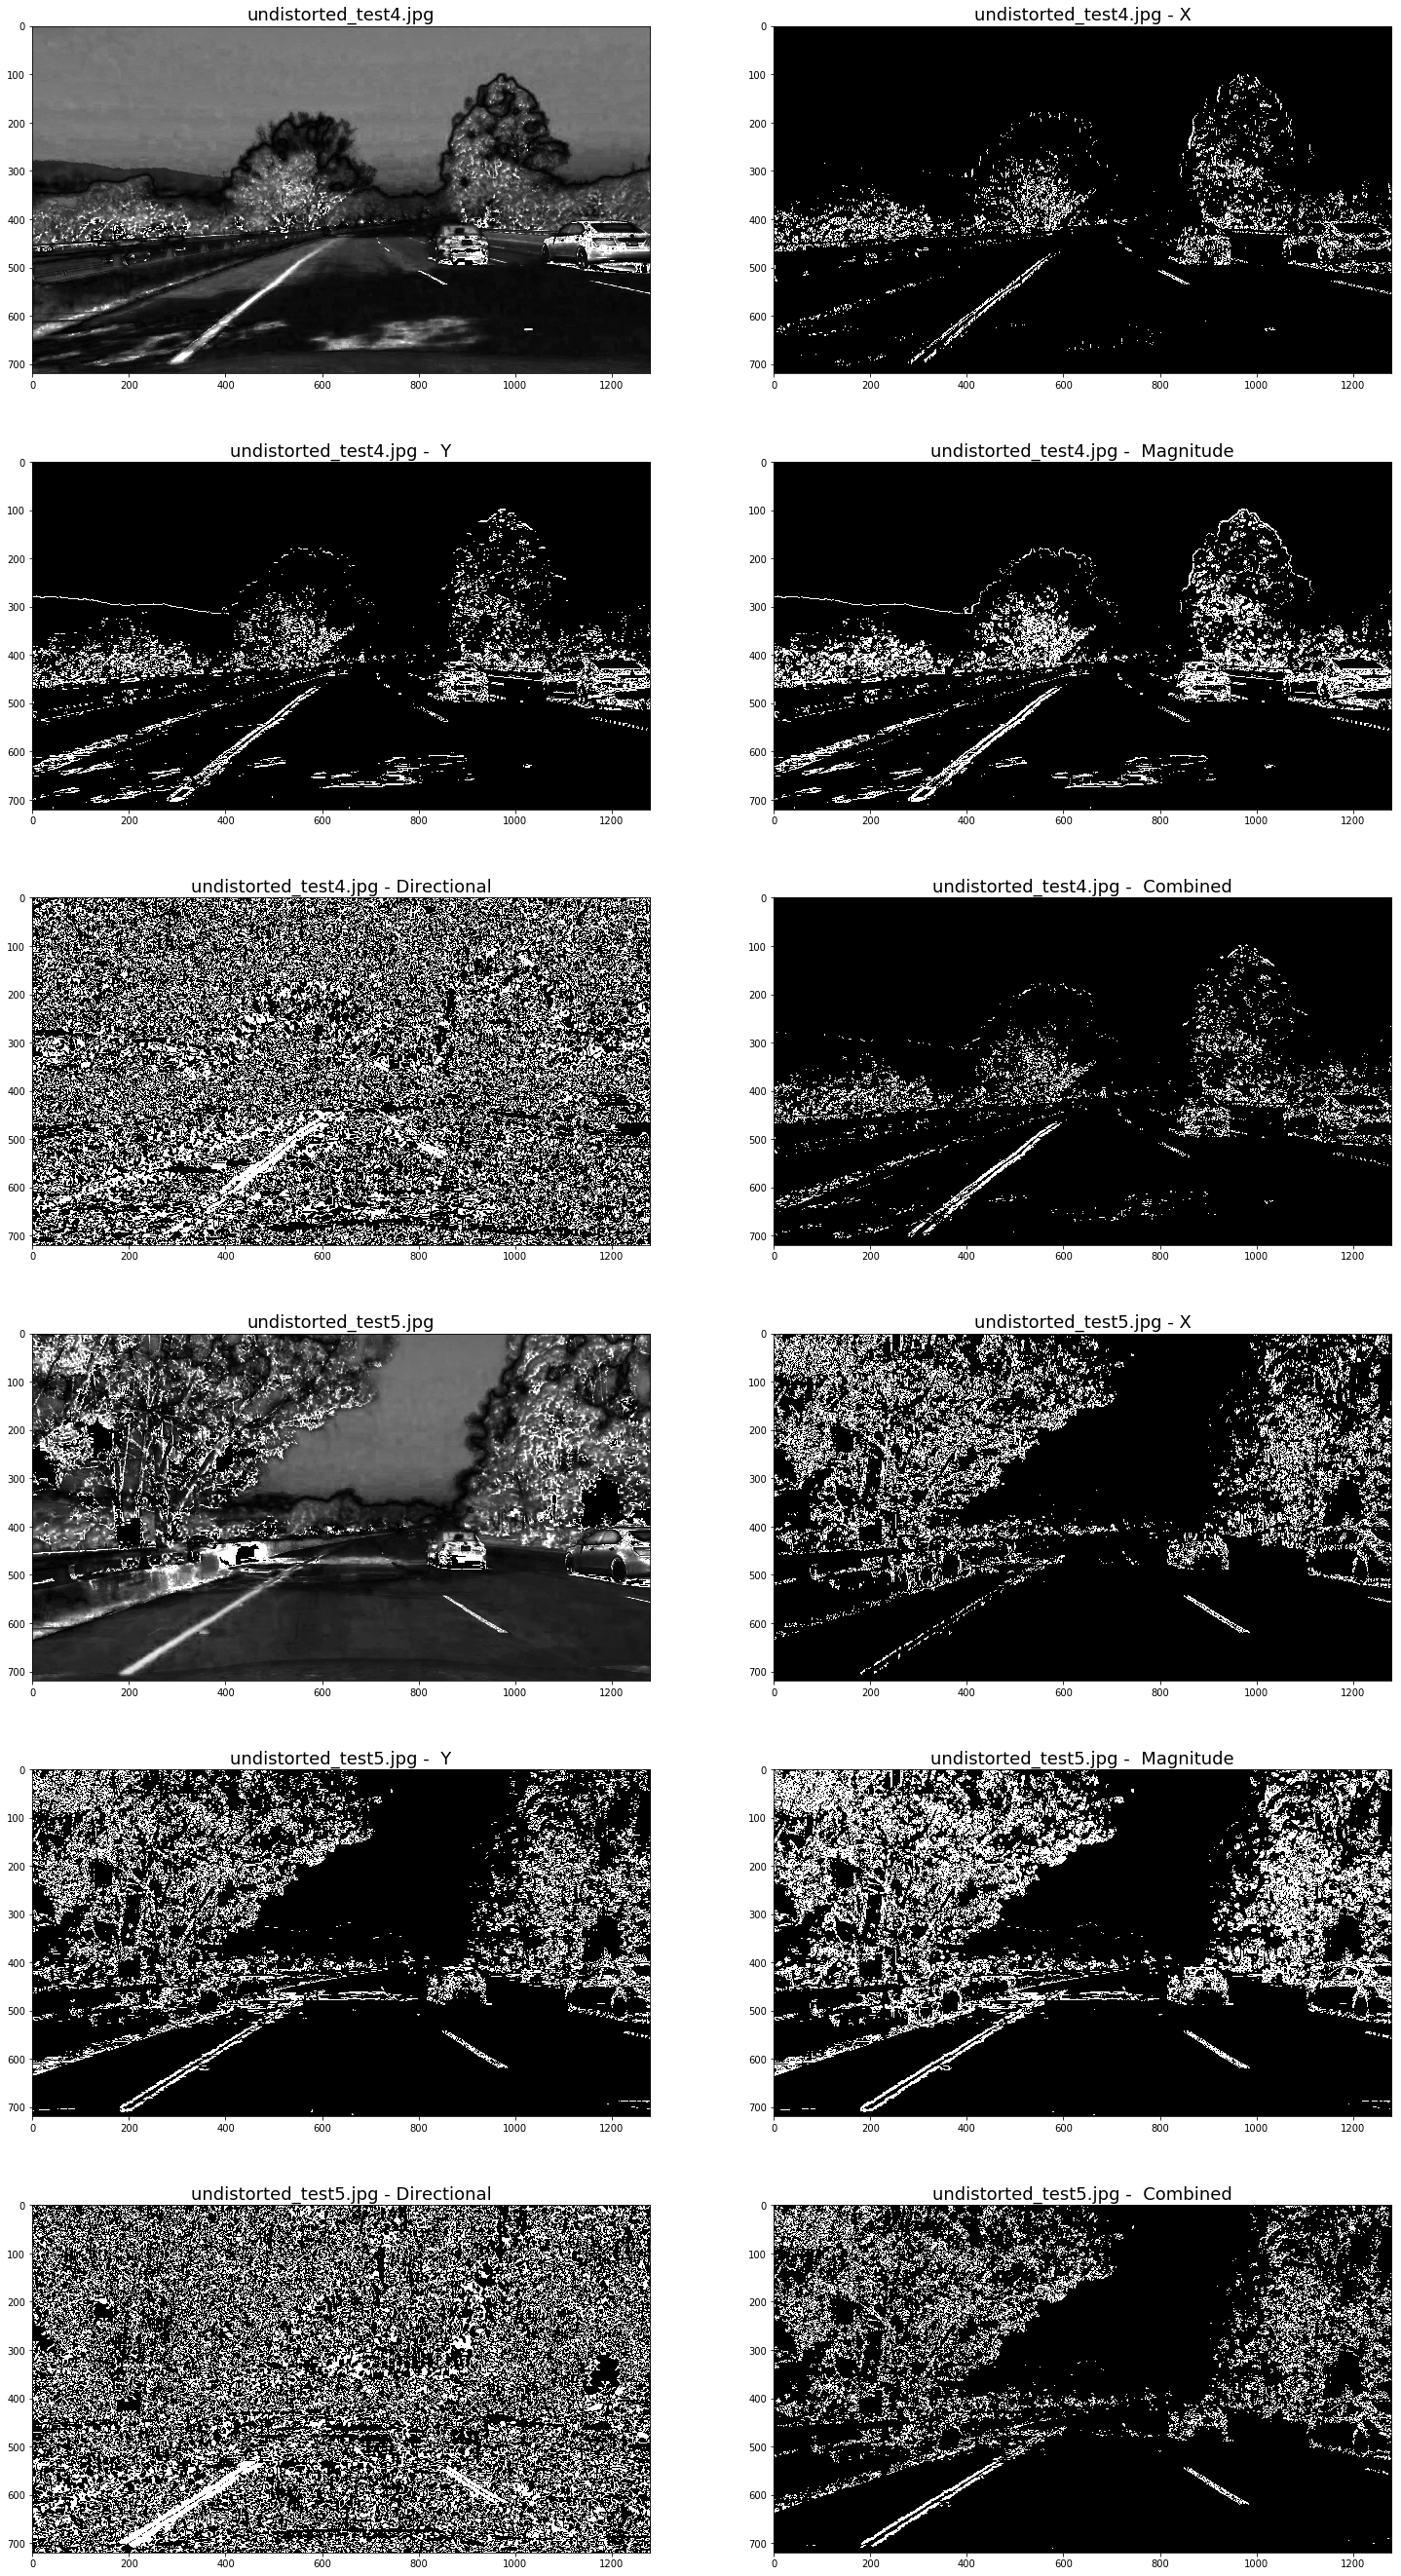

In [5]:
# row for binary mask, gradient threshold, and final row to show final combined next to original 
fig, axes = plt.subplots(6, 2, figsize=(25,8 * 6))

for i in range(3,5):
    fname = images[i]
    title = fname.split('/')[1].split('\\')[1]
    i = i-3
    
    image = mpimg.imread(fname) # rgb image
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS) # hls image
    
    # s channel
    s_channel = hls[:,:,2]
    
    grad_x = abs_sobel_thresh(s_channel, orient='x', thresh_min=25, thresh_max=150)
    grad_y = abs_sobel_thresh(s_channel, orient='y', thresh_min=25, thresh_max=150)
    grad_xy = np.zeros_like(grad_x)
    grad_xy[(grad_x == 1) & (grad_y == 1)] = 1
    
    mag_binary = mag_thresh(s_channel, sobel_kernel=9, mag_thresh=(25, 150))
    dir_binary = dir_threshold(s_channel, sobel_kernel=15, thresh=(0.7, 1.3))
    
    combined = np.zeros_like(mag_binary)
    combined[(grad_xy == 1) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    
    axes[i*3][0].imshow(s_channel, cmap='gray')
    axes[i*3][0].set_title(title, fontsize=18)

    axes[i*3][1].imshow(grad_x, cmap='gray')
    axes[i*3][1].set_title(title + ' - X', fontsize=18)

    axes[i*3+1][0].imshow(grad_y, cmap='gray')
    axes[i*3+1][0].set_title(title + ' -  Y', fontsize=18)

    axes[i*3+1][1].imshow(mag_binary, cmap='gray')
    axes[i*3+1][1].set_title(title + ' -  Magnitude', fontsize=18)

    axes[i*3+2][0].imshow(dir_binary, cmap='gray')
    axes[i*3+2][0].set_title(title + ' - Directional', fontsize=18)

    axes[i*3+2][1].imshow(combined, cmap='gray')
    axes[i*3+2][1].set_title(title + ' -  Combined', fontsize=18)

print('sobel tests')